# Compare TSPMe and TDFN models

In this notebook we compare the TSPMe and TDFN models, which corresponds to Section 4.1 of the paper. The results in the section can also be generated running the script `scripts/compare_TSPMe_TDFN.py`. The main difference is that in the script the different functions are wrapped as functions while here they are explicitly written.

The goal of this notebook is to compare the reduced model (TSPMe) against a full model (TDFN) to validate the resuts of the former.

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from tec_reduced_model.set_parameters import set_thermal_parameters

plt.style.use(['science','vibrant'])

plt.rcParams.update({
    "font.family": "sans-serif",
    "text.usetex": False,
    "font.size": 8,
    "axes.labelsize": 10,
})

We first need to define the simulations parameters:

In [2]:
# Change simulation parameters here
temperature = 25  # in degC, valid values: 0, 10, 25
Crate = 1         # valid values: 0.5, 1, 2

Then we define the models and solve them for a CC discharge at the C-rate and temperature previously defined:

In [3]:
# Define the models
models = [
    pybamm.lithium_ion.SPMe(
        options={
            "thermal": "lumped",
            "dimensionality": 0,
            "cell geometry": "arbitrary",
            "electrolyte conductivity": "integrated",
        },
        name="TDFN",
    ),
    pybamm.lithium_ion.DFN(
        options={
            "thermal": "lumped",
            "dimensionality": 0,
            "cell geometry": "arbitrary",
        },
        name="TDFN",
    ),
]

# Define parameter set Chen 2020 (see PyBaMM documentation for details)
# This is the reference parameter set, which we then update for the adjusted thermal parameters
param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)
param = set_thermal_parameters(param, 20, 2.85e6, temperature)
param["Ambient temperature [K]"] = 273.15 + temperature
param["Initial temperature [K]"] = 273.15 + temperature

simulations = [None] * len(models)
solutions = [None] * len(models)

# Solve the models and store the solutions
for i, model in enumerate(models):
    sim = pybamm.Simulation(
        model,
        parameter_values=param,
        C_rate=Crate,
    )
    sim.solve([0, 3700 / Crate])
    solutions[i] = sim.solution
    simulations[i] = sim

We now compute the error between the two solutions and print the peak error and RMSE for both voltage and temperature:

In [4]:
sol_TSPMe = solutions[0]
sol_TDFN = solutions[1]
if sol_TSPMe["Time [s]"].entries[-1] < sol_TDFN["Time [s]"].entries[-1]:
    time = sol_TSPMe["Time [s]"].entries
else:
    time = sol_TDFN["Time [s]"].entries
error_V = sol_TSPMe["Terminal voltage [V]"](time) - sol_TDFN[
    "Terminal voltage [V]"
](time)
error_T = sol_TSPMe["X-averaged cell temperature [K]"](time) - sol_TDFN[
    "X-averaged cell temperature [K]"
](time)

error = {}
error["V"] = error_V
error["RMSE_V"] = np.sqrt(np.mean(error_V ** 2))
error["peak_V"] = np.max(np.abs(error_V))
error["T"] = error_T
error["RMSE_T"] = np.sqrt(np.mean(error_T ** 2))
error["peak_T"] = np.max(np.abs(error_T))

print("Voltage RMSE: {:.2f} mV".format(error["RMSE_V"] * 1000))
print("Voltage peak error: {:.2f} mV".format(error["peak_V"] * 1000))
print("Temperature RMSE: {:.2f} °C".format(error["RMSE_T"]))
print("Temperature peak error: {:.2f} °C".format(error["peak_T"]))

Voltage RMSE: 5.59 mV
Voltage peak error: 16.35 mV
Temperature RMSE: 0.15 °C
Temperature peak error: 0.29 °C


And finally we plot the voltage and temperature, and the corresponding errors.

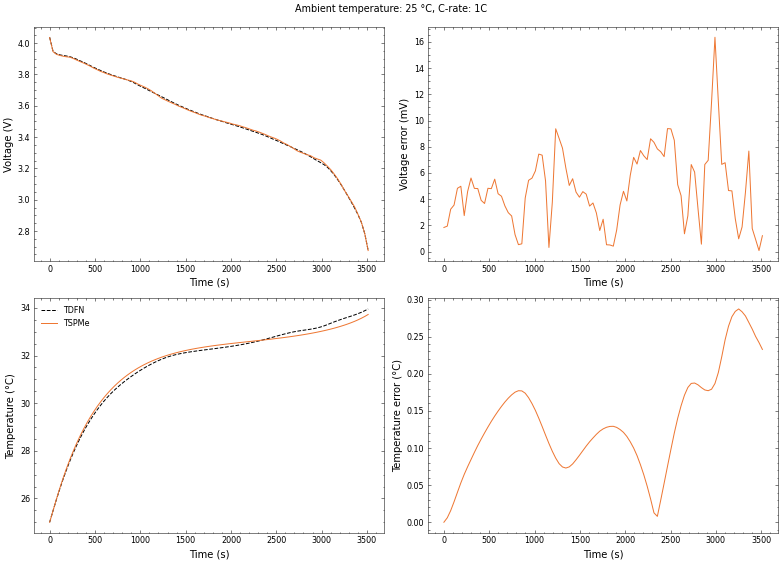

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(11, 8))

# Plot voltage and error
sol_TSPMe = solutions[0]
sol_TDFN = solutions[1]
if sol_TSPMe["Time [s]"].entries[-1] < sol_TDFN["Time [s]"].entries[-1]:
    time = sol_TSPMe["Time [s]"].entries
else:
    time = sol_TDFN["Time [s]"].entries

axes[0, 0].plot(
    sol_TDFN["Time [s]"](time),
    sol_TDFN["Terminal voltage [V]"](time),
    color="black",
    linestyle="dashed",
)

axes[0, 0].plot(
    sol_TSPMe["Time [s]"](time),
    sol_TSPMe["Terminal voltage [V]"](time),
    label="{}C".format(Crate),
)

axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Voltage (V)")

axes[0, 1].plot(time, np.abs(error["V"]) * 1e3)
axes[0, 1].set_xlabel("Time (s)")
axes[0, 1].set_ylabel("Voltage error (mV)")

axes[1, 0].plot(
    sol_TDFN["Time [s]"](time),
    sol_TDFN["X-averaged cell temperature [K]"](time) - 273.15,
    color="black",
    linestyle="dashed",
    label="TDFN"
)

axes[1, 0].plot(
    sol_TSPMe["Time [s]"](time),
    sol_TSPMe["X-averaged cell temperature [K]"](time) - 273.15,
    label="TSPMe",
)

axes[1, 0].set_xlabel("Time (s)")
axes[1, 0].set_ylabel("Temperature (°C)")
axes[1, 0].legend()

axes[1, 1].plot(
    time,
    np.abs(error["T"]),
    label="{}C".format(Crate),
)
axes[1, 1].set_xlabel("Time (s)")
axes[1, 1].set_ylabel("Temperature error (°C)")


fig.suptitle("Ambient temperature: {} °C, C-rate: {}C".format(temperature, Crate))

fig.tight_layout()
fig.subplots_adjust(top=0.94)